<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

<!--NAVIGATION-->
< [Introduction to Folding](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/04.00-Introduction-to-Folding.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Low-Res Scoring and Fragments](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/04.02-Low-Res-Scoring-and-Fragments.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/04.01-Basic-Folding-Algorithm.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Basic Folding Algorithm
Keywords: pose_from_sequence(), random move, scoring move, Metropolis, assign(), Pose()

In [ ]:
# Notebook setup
import sys
if 'google.colab' in sys.modules:
    !pip install pyrosettacolabsetup
    import pyrosettacolabsetup
    pyrosettacolabsetup.setup()
    print ("Notebook is set for PyRosetta use in Colab.  Have fun!")

from pyrosetta import *
from pyrosetta.teaching import *
init()

## Building the Pose

In this workshop, you will be folding a 10 residue protein by building a simple de novo folding algorithm. Start by initializing PyRosetta as usual.

Create a simple poly-alanine `pose` with 10 residues for testing your folding algorithm. Store the pose in a variable called "polyA."

In [35]:
### BEGIN SOLUTION
polyA = pyrosetta.pose_from_sequence('A' * 10)
### END SOLUTION

polyA.pdb_info().name("polyA")

__Question:__
Check the backbone dihedrals of a few residues (except the first and last) using the `.phi()` and `.psi()` methods in `Pose`. What are the values of $\phi$ and $\psi$ dihedrals? You should see ideal bond lengths and angles, but the dihedrals may not be as realistic.

In [36]:
### BEGIN SOLUTION
print("phi: %i" %polyA.phi(9))
print("psi: %i" %polyA.psi(9))
### END SOLUTION

phi: 180
psi: 180


OPTIONAL:
We may want to visualize folding as it happens. Before starting with the folding protocol, instantiate a PyMOL mover and use a UNIQUE port number between 10,000 and 65,536. We will retain history in order to view the entire folding process by utilizing the `.keep_history()` method. Make sure it says `PyMOL <---> PyRosetta link started!` on its command line.

In [37]:
pmm = PyMOLMover()
pmm.keep_history(True)


Use the PyMOL mover to view the `polyA` `Pose`. You should see a long thread-like structure in PyMOL.

In [38]:
pmm.apply(polyA)

## Building A Basic *de Novo* Folding Algorithm

Now, write a program that implements a Monte Carlo algorithm to optimize the protein conformation. You can do this here in the notebook, or you may use a code editor to write a `.py` file and execute in a Python or iPython shell.  

Our main program will include 100 iterations of making a random trial move, scoring the protein, and accepting/rejecting the move. Therefore, we can break this algorithm down into three smaller subroutines: **random, score, and decision.**

### Step 1: Random Move

For the **random** trial move, write a subroutine to choose one residue at random using `random.randint()` and then randomly perturb either the φ or ψ angles by a random number chosen from a Gaussian distribution. Use the Python built-in function `random.gauss()` from the `random` library with a mean of the current angle and a standard deviation of 25°. After changing the torsion angle, use `pmm.apply(polyA)` to update the structure in PyMOL.

In [39]:
import math
import random

def randTrial(your_pose):
### BEGIN SOLUTION
    randNum = random.randint(2, your_pose.total_residue())
    currPhi = your_pose.phi(randNum)
    currPsi = your_pose.psi(randNum)
    newPhi = random.gauss(currPhi, 25)
    newPsi = random.gauss(currPsi, 25)
    your_pose.set_phi(randNum,newPhi) 
    your_pose.set_psi(randNum,newPsi)
    pmm.apply(your_pose)
### END SOLUTION
    return your_pose

### Step 2: Scoring Move

For the **scoring** step, we need to create a scoring function and make a subroutine that simply returns the numerical energy score of the pose.

In [40]:
sfxn = get_fa_scorefxn()

def score(your_pose):
    ### BEGIN SOLUTION
    return sfxn(your_pose)
    ### END SOLUTION

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015


### Step 3: Accepting/Rejecting Move
For the **decision** step, we need to make a subroutine that either accepts or rejects the new conformatuon based on the Metropolis criterion. The Metropolis criterion has a probability of accepting a move as $P = \exp( -\Delta G / kT )$. When $ΔE ≥ 0$, the Metropolis criterion probability of accepting the move is $P = \exp( -\Delta G / kT )$. When $ΔE < 0$, the Metropolis criterion probability of accepting the move is $P = 1$. Use $kT = 1$ Rosetta Energy Unit (REU).

In [41]:
def decision(before_pose, after_pose):
    ### BEGIN SOLUTION
    E = score(after_pose) - score(before_pose)
    if E < 0:
        return after_pose
    elif random.uniform(0, 1) >= math.exp(-E/1):
        return before_pose
    else:
        return after_pose
    ### END SOLUTION

### Step 4: Execution
Now we can put these three subroutines together in our main program! Write a loop in the main program so that it performs 100 iterations of: making a random trial move, scoring the protein, and accepting/rejecting the move. 

After each iteration of the search, output the current pose energy and the lowest energy ever observed. **The final output of this program should be the lowest energy conformation that is achieved at *any* point during the simulation.** Be sure to use `low_pose.assign(pose)` rather than `low_pose = pose`, since the latter will only copy a pointer to the original pose.

In [43]:
def basic_folding(your_pose):
    """Your basic folding algorithm that completes 100 Monte-Carlo iterations on a given pose"""
    
    lowest_pose = Pose() # Create an empty pose for tracking the lowest energy pose.
    
    ### BEGIN SOLUTION
    for i in range(100):
        if i == 0:
            lowest_pose.assign(your_pose)
            
        before_pose = Pose()
        before_pose.assign(your_pose) # keep track of pose before random move

        after_pose = Pose()
        after_pose.assign(randTrial(your_pose)) # do random move and store the pose
        
        your_pose.assign(decision(before_pose, after_pose)) # keep the new pose or old pose
        
        if score(your_pose) < score(lowest_pose): # updating lowest pose
            lowest_pose.assign(your_pose)
        
        print("Iteration # %i" %i) # output   
        print("Current pose score: %1.3f" %score(your_pose)) # output
        print("Lowest pose score: %1.3f" %score(lowest_pose)) # output
        
    ### END SOLUTION
    return lowest_pose

Finally, output the last pose and the lowest-scoring pose observed and view them in PyMOL. Plot the energy and lowest-energy observed vs. cycle number. What are the energies of the initial, last, and lowest-scoring pose? Is your program working? Has it converged to a good solution?


In [44]:
basic_folding(polyA)


Iteration # 0
Current pose score: 29.926
Lowest pose score: 29.926
Iteration # 1
Current pose score: 29.926
Lowest pose score: 29.926
Iteration # 2
Current pose score: 27.155
Lowest pose score: 27.155
Iteration # 3
Current pose score: 26.881
Lowest pose score: 26.881
Iteration # 4
Current pose score: 26.881
Lowest pose score: 26.881
Iteration # 5
Current pose score: 26.881
Lowest pose score: 26.881
Iteration # 6
Current pose score: 25.102
Lowest pose score: 25.102
Iteration # 7
Current pose score: 26.531
Lowest pose score: 25.102
Iteration # 8
Current pose score: 26.531
Lowest pose score: 25.102
Iteration # 9
Current pose score: 26.116
Lowest pose score: 25.102
Iteration # 10
Current pose score: 26.116
Lowest pose score: 25.102
Iteration # 11
Current pose score: 25.488
Lowest pose score: 25.102
Iteration # 12
Current pose score: 24.199
Lowest pose score: 24.199
Iteration # 13
Current pose score: 24.442
Lowest pose score: 24.199
Iteration # 14
Current pose score: 24.442
Lowest pose scor

Here's an example of the PyMOL view:

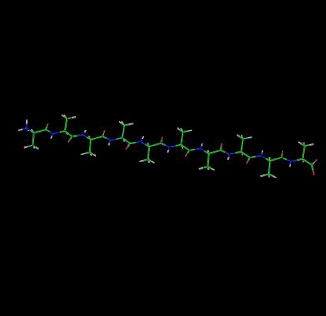

In [1]:
from IPython.display import Image
Image('./Media/folding.gif',width='300')

### Exercise 1: Comparing to Alpha Helices
Using the program you wrote for Workshop #2, force the $A_{10}$ sequence into an ideal α-helix.

**Questions:** Does this helical structure have a lower score than that produced by your folding algorithm above? What does this mean about your sampling or discrimination?

### Exercise 2: Optimizing Algorithm 
Since your program is a stochastic search algorithm, it may not produce an ideal structure consistently, so try running the simulation multiple times or with a different number of cycles (if necessary). Using a kT of 1, your program may need to make up to 500,000 iterations.

<!--NAVIGATION-->
< [Introduction to Folding](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/04.00-Introduction-to-Folding.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Low-Res Scoring and Fragments](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/04.02-Low-Res-Scoring-and-Fragments.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/04.01-Basic-Folding-Algorithm.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>